In [1]:
# Basic imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


2024-03-28 21:47:57.800849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 21:47:57.800894: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 21:47:57.800925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 21:47:57.808428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [3]:
df = pd.concat([train,test])

In [4]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [5]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [7]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [8]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [11]:
X_train

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
102468,102469,0.210396,10,10,1000,4664,90.305896,62,252,3.422118e+04,...,False,False,False,True,False,False,False,False,False,False
64802,64803,5.619431,138,38,162294,2612,31.141943,62,252,2.293727e+05,...,False,False,False,True,False,False,False,False,False,False
33634,33635,0.000977,2,2,132,164,3070.624396,31,29,5.404299e+05,...,False,True,False,False,False,False,False,False,False,False
27874,27875,0.037950,60,62,3614,50036,3188.405658,31,29,7.491962e+05,...,False,False,False,True,False,False,False,False,False,False
99000,99001,0.767809,22,30,1040,18514,66.422771,62,252,1.034632e+04,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37547,37548,0.031852,60,62,3598,48710,3798.819605,31,29,8.888610e+05,...,False,False,False,True,False,False,False,False,False,False
21362,21363,0.191118,22,26,2054,2582,245.921365,31,29,8.208541e+04,...,False,False,False,True,False,False,False,False,False,False
49600,49601,1.394700,12,10,2026,788,15.057001,254,252,1.065749e+04,...,False,False,False,True,False,False,False,False,False,False
64535,64536,0.754238,22,36,1040,26328,75.572961,62,252,1.053248e+04,...,False,False,False,True,False,False,False,False,False,False


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [11]:
logreg_model = LogisticRegression(max_iter=10000, solver='saga')


In [13]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}


In [14]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(logreg_model, param_grid, cv=cv_strategy, scoring='accuracy', verbose=3, n_jobs=-1)

In [15]:
grid_search.fit(X_train_scaled, y_train_encoded)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 4/5] END ................C=0.01, penalty=l2;, score=0.828 total time=  24.3s
[CV 5/5] END ................C=0.01, penalty=l2;, score=0.828 total time=  24.4s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.828 total time=  25.8s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.828 total time=  26.0s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.827 total time=  27.2s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.837 total time=  36.0s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.839 total time=  36.5s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.837 total time=  37.2s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.837 total time=  38.0s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.838 total time=  38.9s
[CV 2/5] END ...................C=1, penalty=l2;, score=0.842 total time= 2.8min
[CV 4/5] END ...................C=1, penalty=l2;, score=0.843 total time= 2.8min
[CV 5/5] END ...............

In [12]:
logreg_model = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=10000)

In [13]:
logreg_model.fit(X_train_scaled, y_train_encoded)


LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='saga')

In [14]:
y_pred = logreg_model.predict(X_test_scaled)


In [15]:
print("Accuracy on test set:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

Accuracy on test set: 0.8481420393907053

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.06      0.11       538
           1       1.00      0.00      0.00       471
           2       0.31      0.02      0.03      3293
           3       0.59      0.89      0.71      8853
           4       0.74      0.79      0.77      4742
           5       0.99      0.97      0.98     11849
           6       1.00      1.00      1.00     18675
           7       0.66      0.62      0.64      2770
           8       0.00      0.00      0.00       318
           9       0.00      0.00      0.00        26

    accuracy                           0.85     51535
   macro avg       0.61      0.44      0.43     51535
weighted avg       0.83      0.85      0.82     51535



/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [16]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)


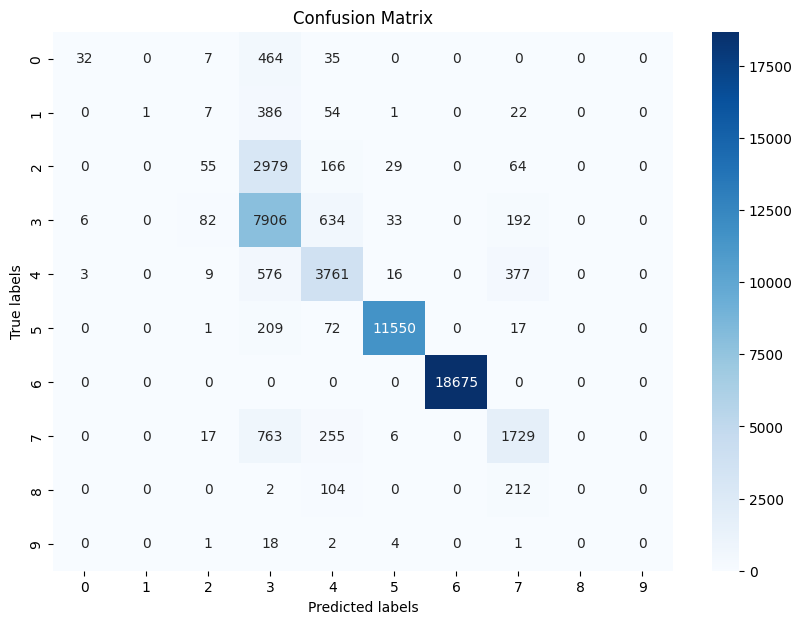

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


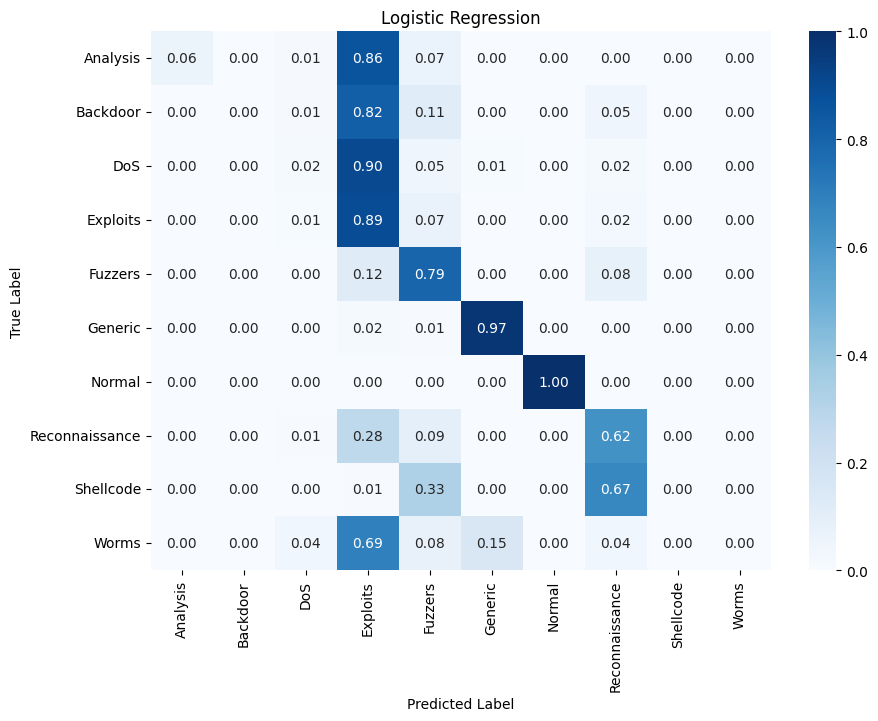

In [19]:
# Normalize the confusion matrix by rows
row_sums = cm.sum(axis=1)
conf_matrix_normalized = cm / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [20]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

accuracy = accuracy_score(y_test_encoded, y_pred)



precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f"Overall Accuracy: {accuracy:.4f}")


Weighted Average Precision: 0.8332
Weighted Average Recall: 0.8481
Weighted Average F1-Score: 0.8193
Micro Average Precision: 0.6076
Micro Average Recall: 0.4363
Micro Average F1-Score: 0.4251
Overall Accuracy: 0.8481


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Basic imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [23]:
df = pd.concat([train,test])

In [24]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [25]:
from itertools import combinations
def data_cleaning(df):
    df.columns=df.columns.str.strip()
    print("Dataset Shape: ",df.shape)
    
    num=df._get_numeric_data()
    num[num<0]=0
    
    zero_variance_cols=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(columns=zero_variance_cols, axis=1, inplace=True)
    print("Zero Variance Columns: ", zero_variance_cols, "are dropped.")
    print("Shape after removing the zero varaince columns: ",df.shape)
    
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    print(df.isna().any(axis=1).sum(),"rows dropped")
    df.dropna(inplace=True)
    print("Shape after Removing NaN: ",df.shape)
    
    df.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates: ",df.shape)
    
    column_pairs = [(i,j) for i,j in combinations(df,2) if df[i].equals(df[j])]
    ide_cols=[]
    for col_pair in column_pairs:
        ide_cols.append(col_pair[1])
    df.drop(columns=ide_cols,axis=1,inplace=True)
    print("Columns which have identical values: ",column_pairs," dropped!")
    print("Shape after removing identical value columns: ",df.shape)
    return df
df=data_cleaning(df)

Dataset Shape:  (257673, 45)
Zero Variance Columns:  [] are dropped.
Shape after removing the zero varaince columns:  (257673, 45)
0 rows dropped
Shape after Removing NaN:  (257673, 45)
Shape after dropping duplicates:  (257673, 45)
Columns which have identical values:  []  dropped!
Shape after removing identical value columns:  (257673, 45)


In [26]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [27]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

In [29]:
# Define the sampling strategies
sampling_strategy_over = {
    "Generic": 50000,
    "Exploits": 45000,
    "Fuzzers": 25000,
    "DoS": 15000,
    "Reconnaissance": 12000,
    "Analysis": 3000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 500
}

sampling_strategy_under = {
    "Normal": 70000
}

over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [30]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())

attack_cat
Normal            70000
Generic           50000
Exploits          45000
Fuzzers           25000
DoS               15000
Reconnaissance    12000
Analysis           3000
Backdoor           2000
Shellcode          2000
Worms               500
Name: count, dtype: int64


In [31]:


# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [33]:
logreg_model = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=10000)

In [34]:
logreg_model.fit(X_train_scaled, y_train_encoded)


LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='saga')

In [35]:
y_pred = logreg_model.predict(X_test_scaled)


In [36]:
print("Accuracy on test set:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

Accuracy on test set: 0.8488794023479189

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.07      0.13       538
           1       1.00      0.00      0.00       471
           2       0.38      0.02      0.03      3293
           3       0.60      0.89      0.71      8853
           4       0.73      0.81      0.77      4742
           5       0.99      0.97      0.98     11849
           6       1.00      1.00      1.00     18675
           7       0.68      0.61      0.64      2770
           8       0.00      0.00      0.00       318
           9       0.44      0.15      0.23        26

    accuracy                           0.85     51535
   macro avg       0.66      0.45      0.45     51535
weighted avg       0.84      0.85      0.82     51535



/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [37]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)


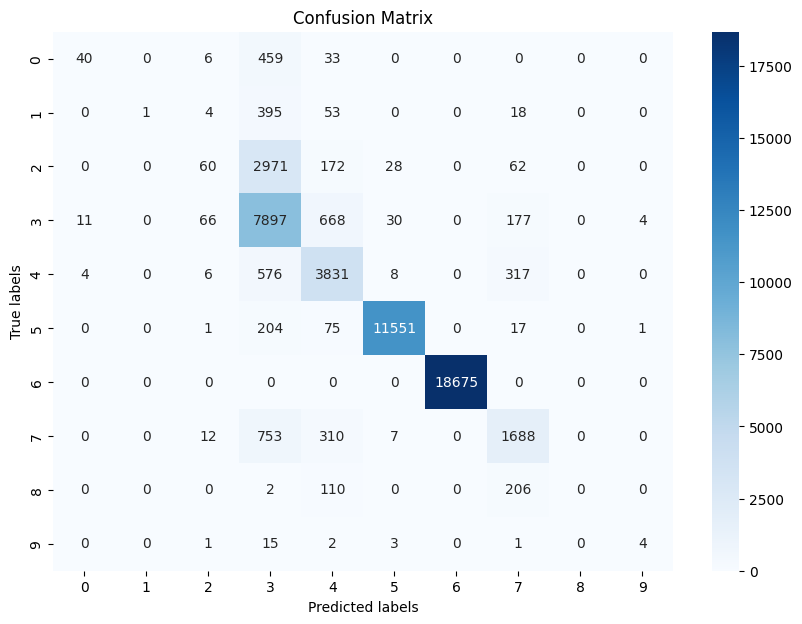

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


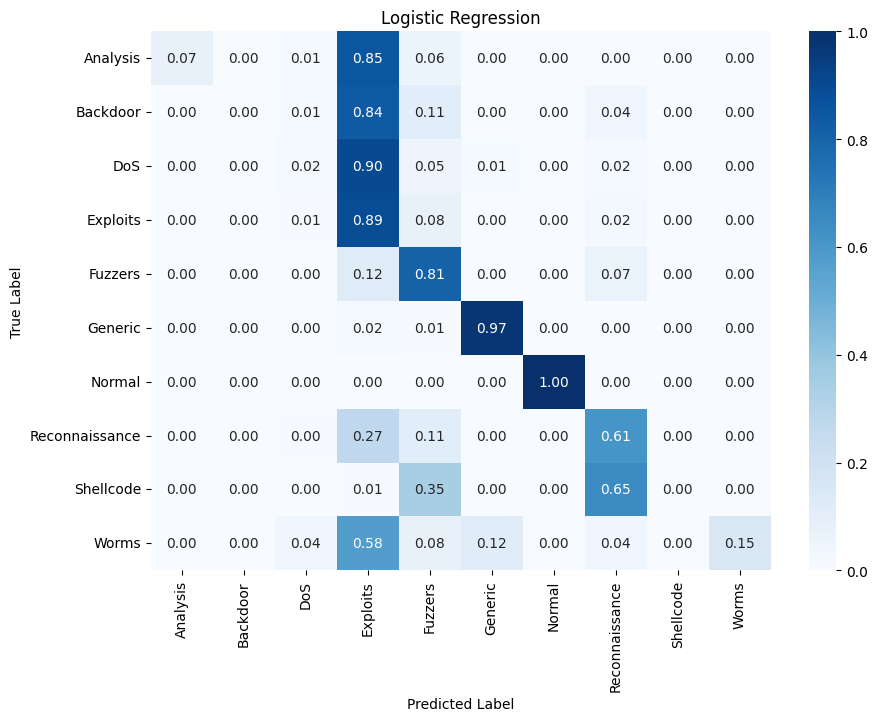

In [39]:
# Normalize the confusion matrix by rows
row_sums = cm.sum(axis=1)
conf_matrix_normalized = cm / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [40]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

accuracy = accuracy_score(y_test_encoded, y_pred)



precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f"Overall Accuracy: {accuracy:.4f}")


Weighted Average Precision: 0.8381
Weighted Average Recall: 0.8489
Weighted Average F1-Score: 0.8201
Micro Average Precision: 0.6553
Micro Average Recall: 0.4533
Micro Average F1-Score: 0.4509
Overall Accuracy: 0.8489


/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
